In [1]:
import numpy as np
import os

from cil.io import TXRMDataReader
from cil.processors import TransmissionAbsorptionConverter
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show_geometry

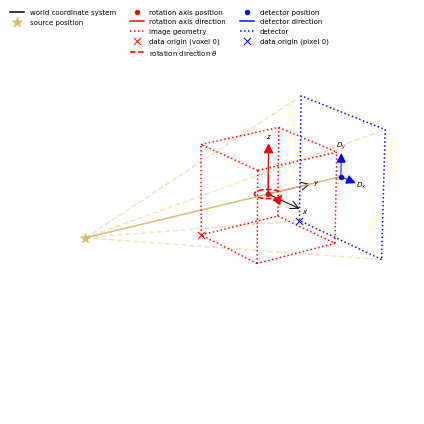

In [2]:
base_dir = os.path.abspath("/mnt/materials/SIRF/Fully3D/CIL/")
data_name = "Walnut"
filename = os.path.join(base_dir, data_name, "valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm")

data = TXRMDataReader(file_name=filename).read()
data = TransmissionAbsorptionConverter()(data)
data.reorder(order='astra')
show_geometry(data.geometry)

# from cil.io import NEXUSDataWriter
# w = NEXUSDataWriter(file_name = os.path.join(os.getcwd(), 'walnut2d.nxs'), data=data2d)
# w.write()

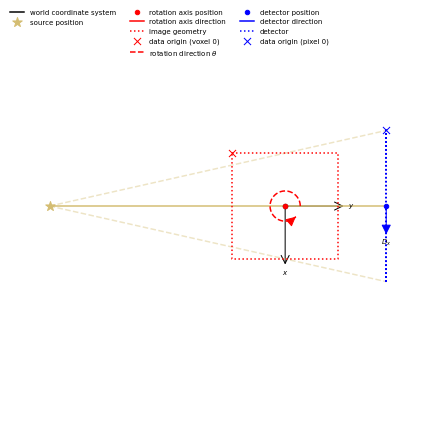

In [3]:
data2d = data.get_slice(vertical='centre')
show_geometry(data2d.geometry)

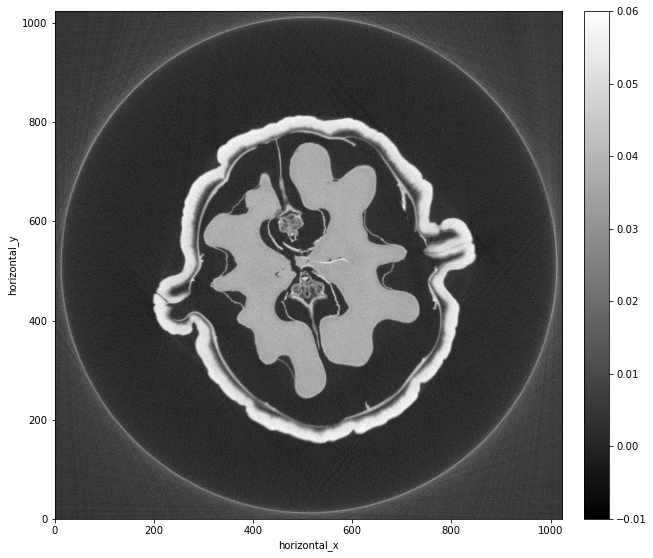

In [4]:
ig = data2d.geometry.get_ImageGeometry()
# ig.voxel_num_x = 200
# ig.voxel_num_y = 200
fbp = FBP(ig, data2d.geometry, 'gpu')
recon = fbp(data2d)
show2D(recon, fix_range=(-0.01, 0.06))

In [5]:
from cil.processors import Slicer

reduce_factor = 10

data_reduced = Slicer(roi={'angle': (0,-1,reduce_factor)})(data2d)

ig = data_reduced.geometry.get_ImageGeometry()
fbp =  FBP(ig, data_reduced.geometry, "gpu")
recon_reduced = fbp(data_reduced)

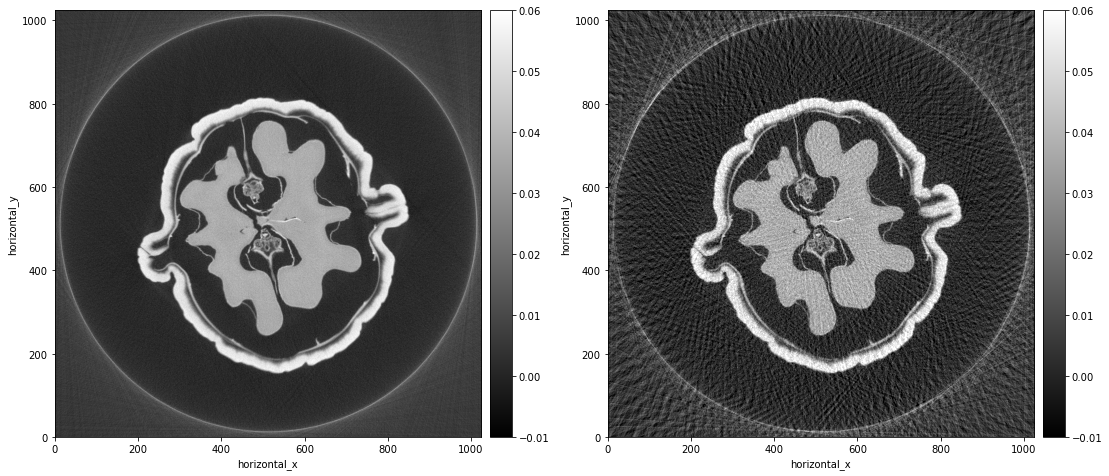

In [6]:
show2D([recon, recon_reduced], fix_range=(-0.01, 0.06))

In [39]:
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import TotalVariation
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.functions import LeastSquares
from cil.plugins.astra import ProjectionOperator

A = ProjectionOperator(ig,data_reduced.geometry)
f = LeastSquares(A=A, b=data_reduced)
alpha = 0.02
# g = alpha * TotalVariation()
g = alpha * FGP_TV(device='gpu')
algo = FISTA(initial=ig.allocate(0), f=f, g=g, max_iteration=100, update_objective_interval=10)

FISTA setting up
FISTA configured


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          3.76543e+04
       10        200         0.187          4.69764e+02
       20        200         0.180          2.10263e+02
       30        200         0.180          1.88750e+02
       40        200         0.180          1.84427e+02
       50        200         0.183          1.82530e+02
       60        200         0.184          1.81676e+02
       70        200         0.187          1.81321e+02
       80        200         0.191          1.81160e+02
       90        200         0.194          1.81098e+02
      100        200         0.196          1.81077e+02
-------------------------------------------------------
      100        200         0.196          1.81077e+02
Stop criterion has been reached.



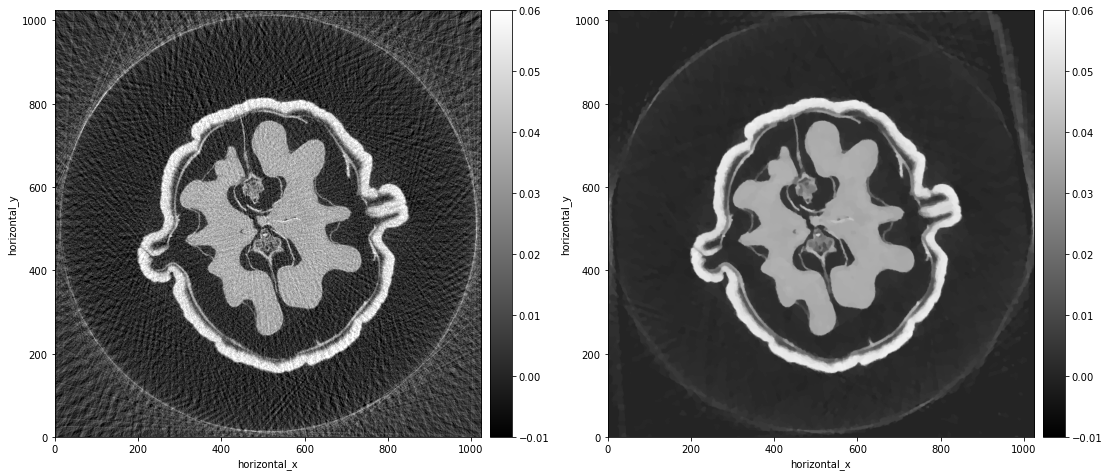

In [40]:
algo.max_iteration += 100
algo.run(100)

show2D([recon_reduced, algo.solution], fix_range=(-0.01, 0.06))

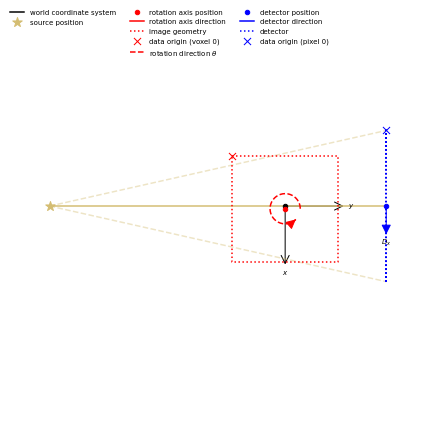

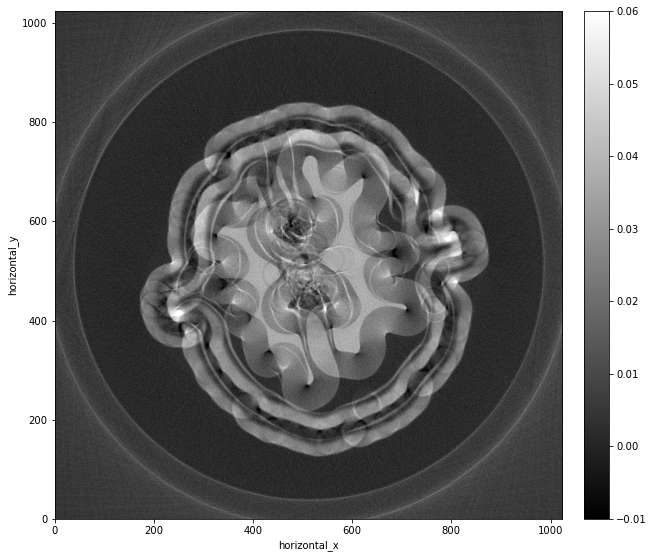

In [7]:
data2d.geometry.config.system.rotation_axis.position = (1.2,0)
show_geometry(data2d.geometry)
fbp = FBP(ig, data2d.geometry, 'gpu')
recon = fbp(data2d)
show2D(recon, fix_range=(-0.01, 0.06))

In [8]:
from cil.processors import CentreOfRotationCorrector

cofr = CentreOfRotationCorrector.image_sharpness(FBP=FBP)
cofr.set_input(data2d)
corrected = cofr.get_output()

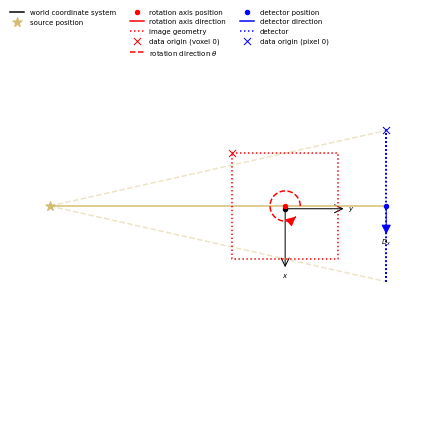

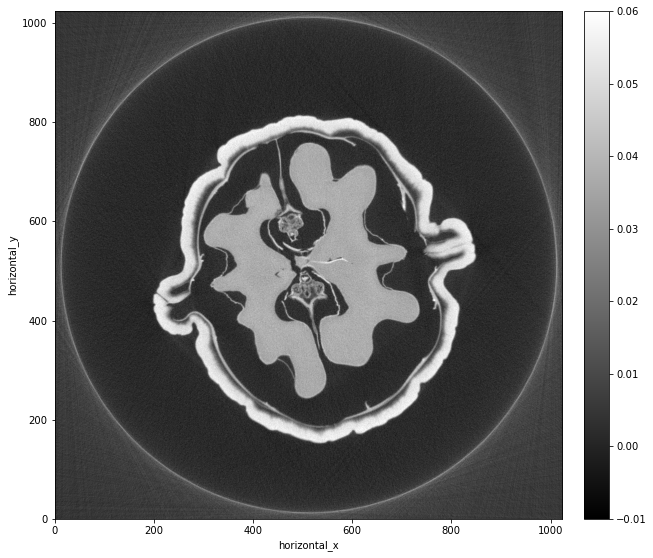

In [9]:
show_geometry(corrected.geometry)
fbp = FBP(ig, corrected.geometry, 'gpu')
reconc = fbp(corrected)
show2D(reconc, fix_range=(-0.01, 0.06))